In [1]:
import numpy as np
from qiskit_optimization import QuadraticProgram
from qiskit import Aer,QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.visualization import plot_histogram
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from itertools import product

# Defining QUBO matrix

In [2]:
# QUBO = np.array([[5,-2],[-2,-3]])
QUBO = np.array([[-4,2],[2,-3]])
QUBO

array([[-4,  2],
       [ 2, -3]])

In [3]:
temp = np.copy(QUBO)
linear = np.diag(QUBO).tolist()
np.fill_diagonal(temp,0)
quadratic = temp.tolist()

In [4]:
linear

[-4, -3]

In [5]:
quadratic

[[0, 2], [2, 0]]

<h3> Solving Qubo using QAOA

In [6]:
model = QuadraticProgram()
for i in range(QUBO.shape[0]):
    model.binary_var('x'+str(i))

model.minimize(linear=linear, quadratic=quadratic)
print(model.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 4 x0 - 3 x1 + [ 8 x0*x1 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1

Binaries
 x0 x1
End



In [7]:
operator,offset = model.to_ising()

In [10]:
print(f'Operator = {operator} \n\n Offset = {offset}')

Operator = 1.0 * IZ
+ 0.5 * ZI
+ 1.0 * ZZ 

 Offset = -2.5


In [11]:
operator.to_matrix()

array([[ 2.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j, -1.5+0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j, -0.5+0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j, -0.5+0.j]])

In [12]:
operator

PauliSumOp(SparsePauliOp(['IZ', 'ZI', 'ZZ'],
              coeffs=[1. +0.j, 0.5+0.j, 1. +0.j]), coeff=1.0)

In [25]:
sampler = Sampler()
optimizer = COBYLA()

qaoa = QAOA(sampler, optimizer, reps=2)
result = qaoa.compute_minimum_eigenvalue(operator)

In [26]:
result.optimal_circuit.draw(fold = -1)

┌───┐┌────────────────────────────────────┐┌───────────────────────────────┐┌────────────────────────────────────┐┌───────────────────────────────┐ ░ ┌─┐   
   q_0: ┤ H ├┤0                                   ├┤0                              ├┤0                                   ├┤0                              ├─░─┤M├───
        ├───┤│  exp(-it (IZ + ZI + ZZ))(1.0*γ[0]) ││  exp(-it (XI + IX))(1.0*β[0]) ││  exp(-it (IZ + ZI + ZZ))(1.0*γ[1]) ││  exp(-it (XI + IX))(1.0*β[1]) │ ░ └╥┘┌─┐
   q_1: ┤ H ├┤1                                   ├┤1                              ├┤1                                   ├┤1                              ├─░──╫─┤M├
        └───┘└────────────────────────────────────┘└───────────────────────────────┘└────────────────────────────────────┘└───────────────────────────────┘ ░  ║ └╥┘
meas: 2/═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩═
                                                                                                                                                               0  1

In [27]:
result.optimal_parameters

{ParameterVectorElement(β[0]): 0.5478381467534201,
 ParameterVectorElement(β[1]): -0.533116652226791,
 ParameterVectorElement(γ[0]): 4.463365298880732,
 ParameterVectorElement(γ[1]): 5.127985657849474}

In [28]:
circuit = result.optimal_circuit.bind_parameters(result.optimal_parameters)

In [29]:
circuit.draw(fold=-1)

┌───┐┌────────────────────────────────────────────┐┌───────────────────────────────────────┐┌────────────────────────────────────────────┐┌─────────────────────────────────────────┐ ░ ┌─┐   
   q_0: ┤ H ├┤0                                           ├┤0                                      ├┤0                                           ├┤0                                        ├─░─┤M├───
        ├───┤│  exp(-it (IZ + ZI + ZZ))(4.46336529888073) ││  exp(-it (XI + IX))(0.54783814675342) ││  exp(-it (IZ + ZI + ZZ))(5.12798565784947) ││  exp(-it (XI + IX))(-0.533116652226791) │ ░ └╥┘┌─┐
   q_1: ┤ H ├┤1                                           ├┤1                                      ├┤1                                           ├┤1                                        ├─░──╫─┤M├
        └───┘└────────────────────────────────────────────┘└───────────────────────────────────────┘└────────────────────────────────────────────┘└─────────────────────────────────────────┘ ░  ║ └╥┘
meas: 2/═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩═
                                                                                                                                                                                                 0  1

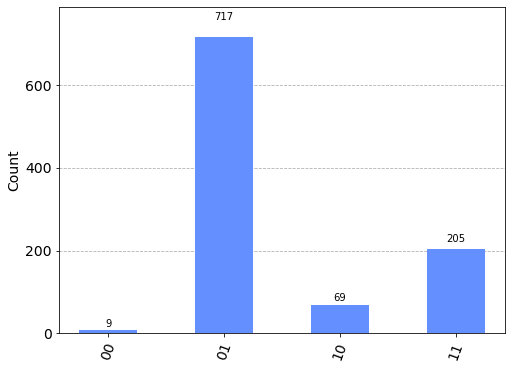

In [30]:
simulate = execute(circuit, backend=Aer.get_backend("qasm_simulator"), shots=1000)
QAOA_results = simulate.result()
plot_histogram(QAOA_results.get_counts(),figsize = (8,6))

<h3> Solving Qubo using D' wave quantum annealer

In [31]:
from decimal import Decimal
import dimod
from dwave.system import EmbeddingComposite, DWaveSampler
from dwave.system import LeapHybridSampler

In [44]:
def annealer_solver(qubo_matrix,backend="Classical",shots =1000):
    qubo_dict = {}

    for i in range(qubo_matrix.shape[0]):
        for j in range(qubo_matrix.shape[1]):
            if i == j:
                qubo_dict[(i,j)] = qubo_matrix[i,j]
            elif i != j:
                qubo_dict[(i,j)] = qubo_matrix[i,j]
            else:
                pass


    # bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(QUBO)
    bqm = dimod.BinaryQuadraticModel.from_qubo(qubo_dict)

    if backend == "Classical":
        print("\nPlease wait, while the Classical engine is running....")
        sampleset = dimod.SimulatedAnnealingSampler().sample(bqm, num_reads=shots)

    elif backend == "Quantum":
        print("\nPlease wait, while the Quantum engine is running....")
        sampleset = EmbeddingComposite(DWaveSampler()).sample(bqm, num_reads=shots)

    elif backend == "Hybrid":
        print("\nPlease wait, while the Hybrid Classical-Quantum engine is running....")
        sampleset = LeapHybridSampler().sample(bqm)
    
    else:
        print("\n\nPlease select a valid backend!")
        pass

    best_sample = list(sampleset.first.sample.values())
    return (best_sample)

In [45]:
classical_sol = annealer_solver(qubo_matrix=QUBO)


Please wait, while the Classical engine is running....


In [46]:
classical_sol

[1, 0]

In [47]:
quantum_sol = annealer_solver(qubo_matrix=QUBO,backend='Quantum')


Please wait, while the Quantum engine is running....


In [48]:
quantum_sol

[1, 0]

In [49]:
h_sol = annealer_solver(qubo_matrix=QUBO,backend='Hybrid')


Please wait, while the Hybrid Classical-Quantum engine is running....


In [50]:
h_sol

[1, 0]

# Eg: Selecting optimum stocks 

In [51]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [52]:
stocks=['TSLA','AMZN','AAPL','NFLX','GOOG']
start_date = '2020-01-01'
end_date = '2022-01-01'

In [53]:
df=pd.DataFrame()

for stock in stocks:
    df[stock] = yf.Ticker(stock).history(start = start_date, end = end_date, interval = '1d')['Close']

In [54]:
df

,TSLA,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2019-12-31,27.888666,92.391998,71.920578,323.570007,66.850998
2020-01-02,28.684000,94.900497,73.561554,329.809998,68.368500
2020-01-03,29.534000,93.748497,72.846375,325.899994,68.032997
2020-01-06,30.102667,95.143997,73.426826,335.829987,69.710503
2020-01-07,31.270666,95.343002,73.081512,330.750000,69.667000
...,...,...,...,...,...
2021-12-27,364.646667,169.669495,179.289444,613.119995,148.063995
2021-12-28,362.823334,170.660995,178.255432,610.710022,146.447998
2021-12-29,362.063324,169.201004,178.344925,610.539978,146.504501


<AxesSubplot:xlabel='Date'>

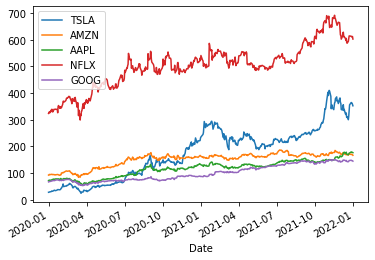

In [55]:
df.plot()

In [56]:
daily_returns = df.pct_change().dropna()
daily_returns

,TSLA,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2020-01-02,0.028518,0.027151,0.022817,0.019285,0.022700
2020-01-03,0.029633,-0.012139,-0.009722,-0.011855,-0.004907
2020-01-06,0.019255,0.014886,0.007968,0.030469,0.024657
2020-01-07,0.038801,0.002092,-0.004703,-0.015127,-0.000624
2020-01-08,0.049205,-0.007809,0.016086,0.025729,0.007880
...,...,...,...,...,...
2021-12-27,0.025248,-0.008178,0.022975,-0.001580,0.006263
2021-12-28,-0.005000,0.005844,-0.005767,-0.003931,-0.010914
2021-12-29,-0.002095,-0.008555,0.000502,-0.000278,0.000386


In [57]:
mu = daily_returns.mean() * 252
mu

TSLA    1.543589
AMZN    0.346239
AAPL    0.518569
NFLX    0.388661
GOOG    0.436263
dtype: float64

In [58]:
cov = daily_returns.cov() * 252
cov

,TSLA,AMZN,AAPL,NFLX,GOOG
TSLA,0.551973,0.101538,0.129882,0.109640,0.095648
AMZN,0.101538,0.103415,0.080815,0.078112,0.066906
AAPL,0.129882,0.080815,0.140332,0.076702,0.083392
NFLX,0.109640,0.078112,0.076702,0.158071,0.064028
GOOG,0.095648,0.066906,0.083392,0.064028,0.101459


According to MPT, 

$$\min_{\vec{x}}\,\, -x^{T}\mu + \frac{\gamma}{2} x^T \Sigma x$$

In [61]:
mu

TSLA    1.543589
AMZN    0.346239
AAPL    0.518569
NFLX    0.388661
GOOG    0.436263
dtype: float64

In [62]:
np.diag(mu)

array([[1.54358873, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.34623869, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.51856874, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.38866135, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.43626252]])

In [63]:
gamma = 1  #risk aversion parameter
qubo = -1*np.diag(mu) + (gamma/2)*np.array(cov)
qubo

array([[-1.26760247,  0.05076913,  0.06494086,  0.05482025,  0.04782395],
       [ 0.05076913, -0.29453134,  0.04040728,  0.03905576,  0.03345315],
       [ 0.06494086,  0.04040728, -0.44840252,  0.03835085,  0.04169623],
       [ 0.05482025,  0.03905576,  0.03835085, -0.30962583,  0.03201392],
       [ 0.04782395,  0.03345315,  0.04169623,  0.03201392, -0.38553315]])

<h3> Brute force solution

In [64]:
n = qubo.shape[0]
n

5

In [65]:
states = list(product([0,1],repeat = n))

In [66]:
print(f'\t State \t\t\t Cost')
best_cost = 0
for state in states:
    state = np.array(state).reshape(1,n)
    cost = float(state@qubo@state.T)
    print(f' {state} \t {cost}')
    
    if cost < best_cost:
        best_cost = cost
        best_state = state

print(f'Best state: {best_state} \t, cost: {best_cost}')

	 State 			 Cost
 [[0 0 0 0 0]] 	 0.0
 [[0 0 0 0 1]] 	 -0.38553314516372045
 [[0 0 0 1 0]] 	 -0.3096258289095584
 [[0 0 0 1 1]] 	 -0.6311311356059072
 [[0 0 1 0 0]] 	 -0.44840252444077655
 [[0 0 1 0 1]] 	 -0.7505432081975891
 [[0 0 1 1 0]] 	 -0.6813266580292017
 [[0 0 1 1 1]] 	 -0.9194395033186427
 [[0 1 0 0 0]] 	 -0.29453134426996774
 [[0 1 0 0 1]] 	 -0.613158190735144
 [[0 1 0 1 0]] 	 -0.5260456496997536
 [[0 1 0 1 1]] 	 -0.7806446576975582
 [[0 1 1 0 0]] 	 -0.6621193087709183
 [[0 1 1 0 1]] 	 -0.8973536938291866
 [[0 1 1 1 0]] 	 -0.816931918879571
 [[0 1 1 1 1]] 	 -0.9881384654704677
 [[1 0 0 0 0]] 	 -1.2676024733149454
 [[1 0 0 0 1]] 	 -1.5574877122202324
 [[1 0 0 1 0]] 	 -1.4675878026367923
 [[1 0 0 1 1]] 	 -1.6934452030747078
 [[1 0 1 0 0]] 	 -1.5861232701515902
 [[1 0 1 0 1]] 	 -1.7926160476499693
 [[1 0 1 1 0]] 	 -1.7094069041523037
 [[1 0 1 1 1]] 	 -1.8518718431833117
 [[1 1 0 0 0]] 	 -1.4605955599075229
 [[1 1 0 0 1]] 	 -1.6835745001142657
 [[1 1 0 1 0]] 	 -1.582469365749597


<h3> Using annealer

In [67]:
solution_dwave_c = annealer_solver(qubo, backend='Classical')


Please wait, while the Classical engine is running....


In [68]:
solution_dwave_c

[1, 0, 1, 1, 1]

In [69]:
solution_dwave_q = annealer_solver(qubo, backend='Quantum')


Please wait, while the Quantum engine is running....


In [70]:
solution_dwave_q

[1, 0, 1, 1, 1]

In [71]:
solution_dwave_h = annealer_solver(qubo, backend='Hybrid')


Please wait, while the Hybrid Classical-Quantum engine is running....


In [72]:
solution_dwave_h 

[1, 0, 1, 1, 1]

<h3> Using QAOA

In [73]:
qubo

array([[-1.26760247,  0.05076913,  0.06494086,  0.05482025,  0.04782395],
       [ 0.05076913, -0.29453134,  0.04040728,  0.03905576,  0.03345315],
       [ 0.06494086,  0.04040728, -0.44840252,  0.03835085,  0.04169623],
       [ 0.05482025,  0.03905576,  0.03835085, -0.30962583,  0.03201392],
       [ 0.04782395,  0.03345315,  0.04169623,  0.03201392, -0.38553315]])

In [74]:
temp = np.copy(qubo)
linear = np.diag(qubo).tolist()
np.fill_diagonal(temp,0)
quadratic = temp.tolist()

In [75]:
model = QuadraticProgram()
for i in range(qubo.shape[0]):
    model.binary_var('x'+str(i))

model.minimize(linear=linear, quadratic=quadratic)
print(model.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 1.267602473315 x0 - 0.294531344270 x1 - 0.448402524441 x2
      - 0.309625828910 x3 - 0.385533145164 x4 + [ 0.203076515355 x0*x1
      + 0.259763455208 x0*x2 + 0.219280999175 x0*x3 + 0.191295812517 x0*x4
      + 0.161629119880 x1*x2 + 0.156223046960 x1*x3 + 0.133812597397 x1*x4
      + 0.153403390642 x2*x3 + 0.166784922814 x2*x4 + 0.128055676935 x3*x4 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x0 x1 x2 x3 x4
End



In [76]:
operator, offset = model.to_ising()

In [87]:
offset

-1.1311819659391786

In [78]:
print(operator)

0.524624138875556 * IIIIZ
+ 0.0654230121861006 * IIIZI
+ 0.13150365115238852 * IIZII
+ 0.07269252524078199 * IZIII
+ 0.11527294637404592 * ZIIII
+ 0.025384564419347593 * IIIZZ
+ 0.03247043190103298 * IIZIZ
+ 0.020203639984956494 * IIZZI
+ 0.027410124896927873 * IZIIZ
+ 0.019527880869943122 * IZIZI
+ 0.019175423830283304 * IZZII
+ 0.023911976564608355 * ZIIIZ
+ 0.016726574674636074 * ZIIZI
+ 0.020848115351726954 * ZIZII
+ 0.016006959616842918 * ZZIII


In [86]:
(operator.to_matrix()).min()

(-0.7206898772441329+0j)

In [88]:
offset + (operator.to_matrix()).min()

(-1.8518718431833117+0j)

In [99]:
sampler = Sampler()
optimizer = COBYLA()

qaoa = QAOA(sampler, optimizer, reps=3)
result = qaoa.compute_minimum_eigenvalue(operator)

In [100]:
result.optimal_parameters

{ParameterVectorElement(β[0]): 2.2620287335401015,
 ParameterVectorElement(β[1]): 0.6115922954597629,
 ParameterVectorElement(β[2]): -0.7895809408516887,
 ParameterVectorElement(γ[0]): 4.647233805710306,
 ParameterVectorElement(γ[1]): 4.979963408915966,
 ParameterVectorElement(γ[2]): 2.944134139749824}

In [101]:
circuit = result.optimal_circuit.bind_parameters(result.optimal_parameters)

In [105]:
circuit.draw(fold=-1)

┌───┐┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐┌────────────────────────────────────────────────────────────────────┐┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐┌──────────────────────────────────────────────────────────────────────┐┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐┌───────────────────────────────────────────────────────────────────────┐ ░ ┌─┐            
   q_0: ┤ H ├┤0                                                                                                                                                    ├┤0                                                                   ├┤0                                                                                                                                                    ├┤0                                                                     ├┤0                                                                                                                                                    ├┤0                                                                      ├─░─┤M├────────────
        ├───┤│                                                                                                                                                     ││                                                                    ││                                                                                                                                                     ││                                                                      ││                                                                                                                                                     ││                                                                       │ ░ └╥┘┌─┐         
   q_1: ┤ H ├┤1                                                                                                                                                    ├┤1                                                                   ├┤1                                                                                                                                                    ├┤1                                                                     ├┤1                                                                                                                                                    ├┤1                                                                      ├─░──╫─┤M├─────────
        ├───┤│                                                                                                                                                     ││                                                                    ││                                                                                                                                                     ││                                                                      ││                                                                                                                                                     ││                                                                       │ ░  ║ └╥┘┌─┐      
   q_2: ┤ H ├┤2 exp(-it (IIIIZ + IIIZI + IIZII + IZIII + ZIIII + IIIZZ + IIZIZ + IIZZI + IZIIZ + IZIZI + IZZII + ZIIIZ + ZIIZI + ZIZII + ZZIII))(4.64723380571031) ├┤2 exp(-it (XIIII + IXIII + IIXII + IIIXI + IIIIX))(2.2620287335401) ├┤2 exp(-it (IIIIZ + IIIZI + IIZII + IZIII + ZIIII + IIIZZ + IIZIZ + IIZZI + IZIIZ + IZIZI + IZZII + ZIIIZ + ZIIZI + ZIZII + ZZIII))(4.97996340891597) ├┤2 exp(-it (XIIII + IXIII + IIXII + IIIXI + IIIIX))(0.611592295459763) ├┤2 exp(-it (IIIIZ + IIIZI + IIZII + IZIII + ZIIII +

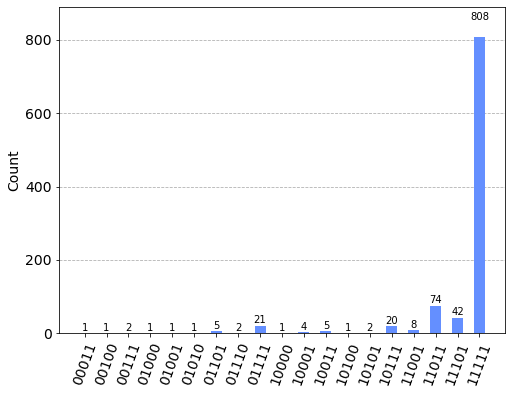

In [106]:
simulate = execute(circuit, backend=Aer.get_backend("qasm_simulator"), shots=1000)
QAOA_results = simulate.result()
plot_histogram(QAOA_results.get_counts(),figsize = (8,6))